In [6]:
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random

In [7]:
dir_path ='data'
daily_path = os.path.join(dir_path,'day')
hourly_path = os.path.join(dir_path,'hour')

daily_data_frames = []
hourly_data_frames = []

for i, area_path in enumerate(os.listdir(daily_path)):
    daily_area_frames = []
    for i,file in enumerate(os.listdir(os.path.join(daily_path,area_path))):
        df = pd.read_csv(os.path.join(daily_path,area_path,file), sep=',') 
        df['t2m']-= 273
        daily_area_frames.append(df)
    daily_data_frames.append(daily_area_frames)

for i, area_path in enumerate(os.listdir(hourly_path)):
    hourly_area_frames = []

    for i,file in enumerate(os.listdir(os.path.join(hourly_path,area_path))):
        df = pd.read_csv(os.path.join(hourly_path,area_path,file), sep=',')  # Using space as separator, skipping first 2 rows
        df['t2m']-= 273
        hourly_area_frames.append(df)
    hourly_data_frames.append(hourly_area_frames)



In [3]:
len(daily_data_frames[1])

5

[0, 4, 1, 2, 3]


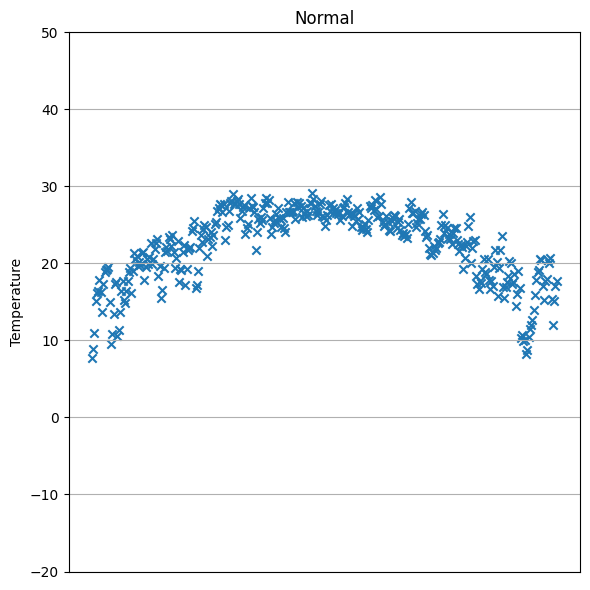

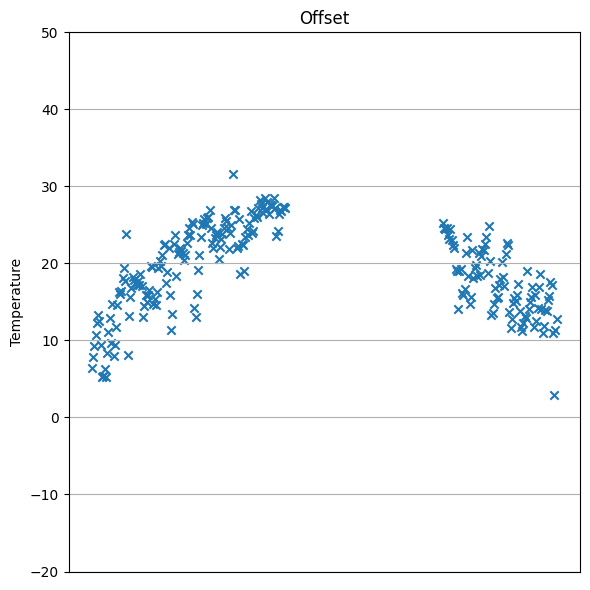

KeyboardInterrupt: 

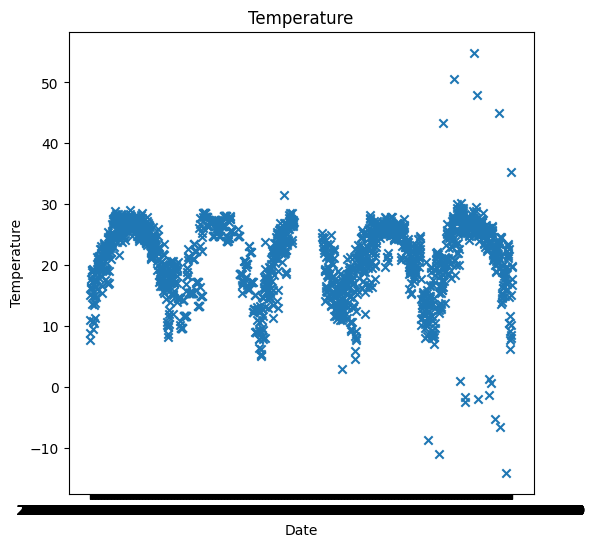

In [7]:
"""
Fault type:
- 0: no fault
- 1: offset fault -- 20% of total interval
- 2: hight noise fault -- 20% of total interval
- 3: outlier fault -- 10% of total interval
- 4: fixed fault -- 20% of total interval
"""
fixed_rate = 0.05
outlier_rate = 0.05
noise_rate = 0.05
offset_rate = 0.05


for i, area_daily_frame in enumerate(daily_data_frames):
    for j, location_daily_frame in enumerate(area_daily_frame):
        numbers = random.sample(range(0, 5), 5)
        print(numbers)
        location_daily_frame['Fault_Label'] = 0
        location_daily_frame['Fault_Type'] = 0
        for k in range(5):
            start = int(len(location_daily_frame) /5 * k)
            end= int(len(location_daily_frame) /5 * (k+1)) - 1
            # print("end",end)
            # print("start",start)
            # print("end",end)
            if(numbers[k] == 0):
                plt.figure(figsize=(6, 6))
                plt.scatter(location_daily_frame['time'][start:end], location_daily_frame['t2m'][start:end], marker='x')
                plt.title(f'Normal')
                plt.xlabel('Date')
                plt.ylabel('Temperature')
                plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                plt.grid()
                plt.gca().get_xaxis().set_visible(False)
                plt.ylim(-20, 50)
                plt.tight_layout()  # Adjust layout to prevent clipping of labels
                plt.show()
                continue

            if(numbers[k] == 1):
                num_offset_faults = int(len(location_daily_frame)/5 *offset_rate)
                # print("offset_rate",num_offset_faults)
                
                fault_indices = random.sample(range(start, end), num_offset_faults)
                # print(fault_indices)
                # Apply a constant offset (e.g., adding 5 degrees)
                pos_neg = random.choices([-1, 1], k = num_offset_faults)

                offset = np.random.uniform(5,6, size=num_offset_faults)
                offset = pos_neg* offset
        
                location_daily_frame.loc[fault_indices, 't2m'] += offset
                location_daily_frame.loc[fault_indices,'Fault_Label'] = 1
                location_daily_frame.loc[fault_indices,'Fault_Type'] = 1
                # print("inject offset fault")
                plt.figure(figsize=(6, 6))
                plt.scatter(location_daily_frame['time'][start:end], location_daily_frame['t2m'][start:end], marker='x')
                plt.title(f'Offset')
                plt.xlabel('Date')
                plt.ylabel('Temperature')
                plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                plt.grid()
                plt.gca().get_xaxis().set_visible(False)
                plt.ylim(-20, 50)
                plt.tight_layout()  # Adjust layout to prevent clipping of labels
                plt.show() 
                
            if(numbers[k] == 2):
                num_gauss_faults = int(len(location_daily_frame)/5 *noise_rate)
                # print("noise",num_offset_faults)
                
                fault_indices = random.sample(range(start, end), num_gauss_faults)
                # print(fault_indices)
                                
                temperature_range = location_daily_frame.loc[start:end, 't2m']
                # print(location_daily_frame.iloc[start:start+1])
                # print(np.mean(temperature_range))
                noise = np.random.normal(np.mean(temperature_range), 1, size=len(fault_indices))
                location_daily_frame.loc[fault_indices,'t2m'] = noise
                location_daily_frame.loc[fault_indices, 'Fault_Label'] = 1
                location_daily_frame.loc[fault_indices, 'Fault_Type'] = 2
                # print("inject gauss noise fault")

            if(numbers[k] == 3):
                num_outlier_faults = int(len(location_daily_frame)/5 *outlier_rate)
                # print("noise",num_offset_faults)
                
                fault_indices = random.sample(range(start, end), num_outlier_faults)
                # print(fault_indices)
                pos_neg = random.choices([-1, 1], k = num_outlier_faults)
                
                outlier = np.random.uniform(20, 30, size=num_outlier_faults)
                outlier = pos_neg* outlier
                location_daily_frame.loc[fault_indices,'t2m'] -= outlier
                location_daily_frame.loc[fault_indices,'Fault_Label'] = 1
                location_daily_frame.loc[fault_indices,'Fault_Type'] = 3
                # print("inject outlier fault")

            if(numbers[k] == 4):
                 
                num_fixed_faults = int(len(location_daily_frame)/5 *fixed_rate)
                # print("offset_rate",num_offset_faults)
                
                fault_indices = random.sample(range(start, end-5), num_offset_faults//5)
                sorted(fault_indices)
                for index in fault_indices:
                    fixed_value = location_daily_frame.loc[index]['t2m'] 
                    location_daily_frame.loc[index+1:index+5,'t2m'] = fixed_value
                    location_daily_frame.loc[index+1:index+5,'Fault_Label'] = 1
                    location_daily_frame.loc[index+1:index+5,'Fault_Type'] = 4

                 
                # print("inject fixed fault")       
        # location_daily_frame.to_csv(f'data_injection/day/area{i+1}/area{i+1}_location{j+1}.csv')
            # print(location_daily_frame.loc[fault_indices])
        plt.figure(figsize=(6, 6))
        plt.scatter(location_daily_frame['time'], location_daily_frame['t2m'], marker='x')
        plt.title(f'Temperature')
        plt.xlabel('Date')
        plt.ylabel('Temperature')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.grid()
        plt.gca().get_xaxis().set_visible(False)
        plt.ylim(-20, 50)
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.show() 
        break
    break


In [8]:
"""
Fault type:
- 0: no fault
- 1: offset fault -- 20% of total interval
- 2: hight noise fault -- 20% of total interval
- 3: outlier fault -- 10% of total interval
- 4: fixed fault -- 20% of total interval
"""
fixed_rate = 0.6
outlier_rate = 0.6
noise_rate = 0.6
offset_rate = 0.3


for i, area_daily_frame in enumerate(hourly_data_frames):
    for j, location_daily_frame in enumerate(area_daily_frame):
        numbers = random.sample(range(0, 5), 5)
        # print(numbers)
        location_daily_frame['Fault_Label'] = 0
        location_daily_frame['Fault_Type'] = 0
        for k in range(5):
            start = int(len(location_daily_frame) /5 * k)
            end= int(len(location_daily_frame) /5 * (k+1)) - 1
            # print("end",end)
            # print("start",start)
            # print("end",end)
            if(numbers[k] == 0):
                # plt.figure(figsize=(6, 6))
                # plt.scatter(location_daily_frame['time'][start:start+150], location_daily_frame['t2m'][start:start+150], marker='x')
                # plt.title(f'Fault free')
                # plt.xlabel('Date')
                # plt.ylabel('Temperature')
                # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                # plt.grid()
                # plt.gca().get_xaxis().set_visible(False)
                # plt.ylim(-20, 50)
                # plt.tight_layout()  # Adjust layout to prevent clipping of labels
                # plt.show()
                continue
            
            if(numbers[k] == 1):
                num_offset_faults = int(len(location_daily_frame)/5 *offset_rate)
                # print("offset_rate",num_offset_faults)
                
                fault_indices = random.sample(range(start, end), num_offset_faults)
                # print(fault_indices)
                # Apply a constant offset (e.g., adding 5 degrees)
                pos_neg = random.choices([-1, 1], k = num_offset_faults)

                offset = np.random.uniform(5,6, size=num_offset_faults)
                offset = pos_neg* offset
        
                location_daily_frame.loc[fault_indices, 't2m'] += offset
                location_daily_frame.loc[fault_indices,'Fault_Label'] = 1
                location_daily_frame.loc[fault_indices,'Fault_Type'] = 1
                # print("inject offset fault")
                # plt.figure(figsize=(6, 6))
                # plt.scatter(location_daily_frame['time'][start:start+150], location_daily_frame['t2m'][start:start+150], marker='x')
                # plt.title(f'Offset Fault')
                # plt.xlabel('Date')
                # plt.ylabel('Temperature')
                # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                # plt.grid()
                # plt.ylim(-20, 50)
                # plt.gca().get_xaxis().set_visible(False)
                # plt.tight_layout()  # Adjust layout to prevent clipping of labels
                # plt.show()
                
            if(numbers[k] == 2):
                num_gauss_faults = int(len(location_daily_frame)/5 *noise_rate)
                # print("noise",num_offset_faults)
                
                fault_indices = random.sample(range(start, end), num_gauss_faults)
                # print(fault_indices)
                                
                temperature_range = location_daily_frame.loc[start:end, 't2m']
                # print(location_daily_frame.iloc[start:start+1])
                # print(np.mean(temperature_range))
                noise = np.random.normal(np.mean(temperature_range), 1, size=len(fault_indices))
                location_daily_frame.loc[fault_indices,'t2m'] = noise
                location_daily_frame.loc[fault_indices, 'Fault_Label'] = 1
                location_daily_frame.loc[fault_indices, 'Fault_Type'] = 2
                # print("inject gauss noise fault")
                # plt.figure(figsize=(6, 6))
                # plt.scatter(location_daily_frame['time'][start:start+150], location_daily_frame['t2m'][start:start+150], marker='x')
                # plt.title(f'Gausian Noise Fault')
                # plt.xlabel('Date')
                # plt.ylabel('Temperature')
                # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                # plt.grid()
                # plt.ylim(-20, 50)
                # plt.gca().get_xaxis().set_visible(False)
                # plt.tight_layout()  # Adjust layout to prevent clipping of labels
                # plt.show()

            if(numbers[k] == 3):
                num_outlier_faults = int(len(location_daily_frame)/5 *outlier_rate)
                # print("noise",num_offset_faults)
                
                fault_indices = random.sample(range(start, end), num_outlier_faults)
                # print(fault_indices)
                pos_neg = random.choices([-1, 1], k = num_outlier_faults)
                
                outlier = np.random.uniform(20, 30, size=num_outlier_faults)
                outlier = pos_neg* outlier
                location_daily_frame.loc[fault_indices,'t2m'] -= outlier
                location_daily_frame.loc[fault_indices,'Fault_Label'] = 1
                location_daily_frame.loc[fault_indices,'Fault_Type'] = 3
                # print("inject outlier fault")
                # plt.figure(figsize=(6, 6))
                # plt.scatter(location_daily_frame['time'][start:start+150], location_daily_frame['t2m'][start:start+150], marker='x')
                # plt.title(f'Outlier Fault')
                # plt.xlabel('Date')
                # plt.ylabel('Temperature')
                # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                # plt.grid()
                # plt.ylim(-20, 50)
                # plt.gca().get_xaxis().set_visible(False)
                # plt.tight_layout()  # Adjust layout to prevent clipping of labels
                # plt.show()

            if(numbers[k] == 4):
                 
                num_fixed_faults = int(len(location_daily_frame)/5 *fixed_rate)
                # print("offset_rate",num_offset_faults)
                
                fault_indices = random.sample(range(start, end-5), num_fixed_faults//5)
                sorted(fault_indices)
                for index in fault_indices:
                    fixed_value = location_daily_frame.loc[index]['t2m'] 
                    location_daily_frame.loc[index+1:index+5,'t2m'] = fixed_value
                    location_daily_frame.loc[index+1:index+5,'Fault_Label'] = 1
                    location_daily_frame.loc[index+1:index+5,'Fault_Type'] = 4
                # print("inject fixed fault")
                # plt.figure(figsize=(6, 6))
                # plt.scatter(location_daily_frame['time'][start:start+150], location_daily_frame['t2m'][start:start+150], marker='x')
                # plt.title(f'Fixed Fault')
                # plt.xlabel('Date')
                # plt.ylabel('Temperature')
                # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
                # plt.grid()
                # plt.ylim(-20, 50)
                # plt.gca().get_xaxis().set_visible(False)
                # plt.tight_layout()  # Adjust layout to prevent clipping of labels
                # plt.show()        
        location_daily_frame.to_csv(f'data_injection/hour/area{i+1}/area{i+1}_location{j+1}.csv')
        
        # plt.figure(figsize=(6, 6))
        # plt.scatter(location_daily_frame['time'][0:150], location_daily_frame['t2m'][0:150], marker='x')
        # plt.title(f'Temperature')
        # plt.xlabel('Date')
        # plt.ylabel('Fault')
        # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        # plt.grid()
        # plt.gca().get_xaxis().set_visible(False)
        # plt.ylim(-20, 50)
        # plt.tight_layout()  # Adjust layout to prevent clipping of labels
        # plt.show()
        
